In [1]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
import warnings
from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
class KNN:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict(self, X_test, distance_func='euclidean', feature_rep='original',test_mode=False):
        if feature_rep == 'svd_low':
            svd = TruncatedSVD(n_components=1)
            X = svd.fit_transform(self.X)
            X_test = svd.transform(X_test)
        elif feature_rep == 'svd_high':
            svd = TruncatedSVD(n_components=2)
            X = svd.fit_transform(self.X)
            X_test = svd.transform(X_test)
        elif feature_rep == 'ae_5':
            encoder = MLPRegressor(hidden_layer_sizes=(2,2), activation='relu')
            encoder.fit(self.X, self.X)
            X = encoder.predict(self.X)
            X_test = encoder.predict(X_test)
        elif feature_rep == 'ae_20':
            encoder = MLPRegressor(hidden_layer_sizes=(6,6), activation='relu')
            encoder.fit(self.X, self.X)
            X = encoder.predict(self.X)
            X_test = encoder.predict(X_test)
        else:
            X = self.X

        distances = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            if distance_func == 'euclidean':
                distances[i] = np.linalg.norm(X[i] - X_test)
            elif distance_func == 'manhattan':
                distances[i] = np.sum(np.abs(X[i] - X_test))

        nearest_neighbors = self.y[np.argsort(distances)][:self.k]
        counts = np.bincount(nearest_neighbors)
        if test_mode:
            return np.argsort(distances)[:self.k], np.argmax(counts) 
        return np.argmax(counts)


In [2]:
# breast cancer
ds = pd.read_csv('./data/data.csv')
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [3]:
ds.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


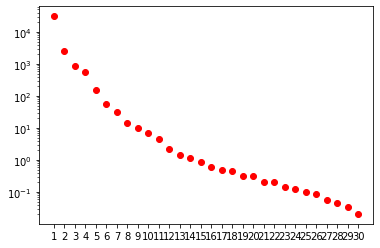

In [4]:
y = ds['diagnosis']
X = ds.drop('diagnosis', axis=1)
X = X.drop('id', axis=1)
i = len(X.columns)
X = X.drop(X.columns[i-1], axis=1)
y.replace(('M', 'B'), (1, 0), inplace=True)
U, s, V = np.linalg.svd(X)
xaxis=np.arange(1,31)
plt.semilogy(xaxis,s,"ro")
plt.xticks(xaxis)
plt.savefig('./images/svd.png')
plt.show()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=6)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
k_list=[1,3,5,7,9,11]
accuracy_list=[]
for k in k_list:
    

    knn = KNN(k)

    acc_scores = []
    f1s=[]
    precisions = []
    recalls = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train, y_test = y[train_index],y[test_index]
        X_train = X_train.to_numpy()
        X_test = X_test.to_numpy()
        y_train = y_train.to_numpy()
        y_test = y_test.to_numpy()
        knn.fit(X_train, y_train)
        y_true = y_test
        yhat = []
        for x in X_test:
            yhat.append(knn.predict([x]))
        f1 = f1_score(y_true, yhat)
        precision = precision_score(y_true, yhat)
        recall = recall_score(y_true, yhat)
        acc_score = accuracy_score(y_true,yhat)
        acc_scores.append(acc_score)
        f1s.append(f1)
        precisions.append(precision)
        recalls.append(recall)
    print("k=",k)
    print("accuracy：", sum(acc_scores)/len(acc_scores))
    accuracy_list.append(sum(acc_scores)/len(acc_scores))
index = k_list[accuracy_list.index(max(accuracy_list))]
print('best accuracy with k= ',index)

k= 1
accuracy： 0.9190789473684211
k= 3
accuracy： 0.9278195488721804
k= 5
accuracy： 0.9366541353383457
k= 7
accuracy： 0.9384398496240601
k= 9
accuracy： 0.9296679197994988
k= 11
accuracy： 0.9366854636591478
best accuracy with k=  7


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=6)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

knn = KNN(k=index)
knn.fit(X_train,y_train)

print("E distance")
y_true = y_test
yhat = []
for x in X_test:
    yhat.append(knn.predict([x]))
# assuming y_true and y_pred are the true and predicted binary labels, respectively
acc = accuracy_score(y_true, yhat)
f1 = f1_score(y_true, yhat)
precision = precision_score(y_true, yhat)
recall = recall_score(y_true, yhat)
print("Accuracy:", acc)
print("F1 score:", f1)
print("Precision:", precision)
print("Recall:", recall)

E distance
Accuracy: 0.9521276595744681
F1 score: 0.9433962264150944
Precision: 0.9615384615384616
Recall: 0.9259259259259259


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=6)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
k_list=[1,3,5,7,9,11]
accuracy_list=[]
for k in k_list:
    

    knn = KNN(k)

    acc_scores = []
    f1s=[]
    precisions = []
    recalls = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train, y_test = y[train_index],y[test_index]
        X_train = X_train.to_numpy()
        X_test = X_test.to_numpy()
        y_train = y_train.to_numpy()
        y_test = y_test.to_numpy()
        knn.fit(X_train, y_train)
        y_true = y_test
        yhat = []
        for x in X_test:
            yhat.append(knn.predict([x],distance_func='manhattan'))
        f1 = f1_score(y_true, yhat)
        precision = precision_score(y_true, yhat)
        recall = recall_score(y_true, yhat)
        acc_score = accuracy_score(y_true,yhat)
        acc_scores.append(acc_score)
        f1s.append(f1)
        precisions.append(precision)
        recalls.append(recall)
    print("k=",k)
    print("accuracy：", sum(acc_scores)/len(acc_scores))
    accuracy_list.append(sum(acc_scores)/len(acc_scores))
index = k_list[accuracy_list.index(max(accuracy_list))]
print('best accuracy with k= ',index)


k= 1
accuracy： 0.9278822055137844
k= 3
accuracy： 0.938408521303258
k= 5
accuracy： 0.9454573934837093
k= 7
accuracy： 0.9454573934837093
k= 9
accuracy： 0.9454573934837093
k= 11
accuracy： 0.9348997493734336
best accuracy with k=  5


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=6)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

knn = KNN(k=index)
knn.fit(X_train,y_train)

print("M distance")
y_true = y_test
yhat = []
for x in X_test:
    yhat.append(knn.predict([x],distance_func='manhattan'))
# assuming y_true and y_pred are the true and predicted binary labels, respectively
acc = accuracy_score(y_true, yhat)
f1 = f1_score(y_true, yhat)
precision = precision_score(y_true, yhat)
recall = recall_score(y_true, yhat)
print("Accuracy:", acc)
print("F1 score:", f1)
print("Precision:", precision)
print("Recall:", recall)

M distance
Accuracy: 0.9627659574468085
F1 score: 0.9565217391304348
Precision: 0.9625
Recall: 0.9506172839506173


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=6)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
k_list=[1,3,5,7,9,11]
accuracy_list=[]
for k in k_list:
    

    knn = KNN(k)

    acc_scores = []
    f1s=[]
    precisions = []
    recalls = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train, y_test = y[train_index],y[test_index]
        X_train = X_train.to_numpy()
        X_test = X_test.to_numpy()
        y_train = y_train.to_numpy()
        y_test = y_test.to_numpy()
        knn.fit(X_train, y_train)
        y_true = y_test
        yhat = []
        for x in X_test:
            yhat.append(knn.predict([x],feature_rep='svd_low'))
        f1 = f1_score(y_true, yhat)
        precision = precision_score(y_true, yhat)
        recall = recall_score(y_true, yhat)
        acc_score = accuracy_score(y_true,yhat)
        acc_scores.append(acc_score)
        f1s.append(f1)
        precisions.append(precision)
        recalls.append(recall)
    print("k=",k)
    print("accuracy：", sum(acc_scores)/len(acc_scores))
    accuracy_list.append(sum(acc_scores)/len(acc_scores))
index = k_list[accuracy_list.index(max(accuracy_list))]
print('best accuracy with k= ',index)

k= 1
accuracy： 0.8717418546365915
k= 3
accuracy： 0.8752192982456141
k= 5
accuracy： 0.8980263157894737
k= 7
accuracy： 0.9032894736842106
k= 9
accuracy： 0.9067982456140349
k= 11
accuracy： 0.9068295739348369
best accuracy with k=  11


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=6)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

knn = KNN(k=index)
knn.fit(X_train,y_train)

print("E distance svd_low")
y_true = y_test
yhat = []
for x in X_test:
    yhat.append(knn.predict([x],feature_rep='svd_low'))
from sklearn.metrics import f1_score, precision_score, recall_score
# assuming y_true and y_pred are the true and predicted binary labels, respectively
acc = accuracy_score(y_true, yhat)
f1 = f1_score(y_true, yhat)
precision = precision_score(y_true, yhat)
recall = recall_score(y_true, yhat)
print("Accuracy:", acc)
print("F1 score:", f1)
print("Precision:", precision)
print("Recall:", recall)

E distance svd_low
Accuracy: 0.9308510638297872
F1 score: 0.9182389937106918
Precision: 0.9358974358974359
Recall: 0.9012345679012346


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=6)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
k_list=[1,3,5,7,9,11]
accuracy_list=[]
for k in k_list:
    

    knn = KNN(k)

    acc_scores = []
    f1s=[]
    precisions = []
    recalls = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train, y_test = y[train_index],y[test_index]
        X_train = X_train.to_numpy()
        X_test = X_test.to_numpy()
        y_train = y_train.to_numpy()
        y_test = y_test.to_numpy()
        knn.fit(X_train, y_train)
        y_true = y_test
        yhat = []
        for x in X_test:
            yhat.append(knn.predict([x],feature_rep='svd_high'))
        f1 = f1_score(y_true, yhat)
        precision = precision_score(y_true, yhat)
        recall = recall_score(y_true, yhat)
        acc_score = accuracy_score(y_true,yhat)
        acc_scores.append(acc_score)
        f1s.append(f1)
        precisions.append(precision)
        recalls.append(recall)
    print("k=",k)
    print("accuracy：", sum(acc_scores)/len(acc_scores))
    accuracy_list.append(sum(acc_scores)/len(acc_scores))
index = k_list[accuracy_list.index(max(accuracy_list))]
print('best accuracy with k= ',index)

k= 1
accuracy： 0.913815789473684
k= 3
accuracy： 0.9190789473684211
k= 5
accuracy： 0.9278508771929823
k= 7
accuracy： 0.9331453634085213
k= 9
accuracy： 0.9244047619047618
k= 11
accuracy： 0.9331766917293234
best accuracy with k=  11


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=6)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

knn = KNN(k=index)
knn.fit(X_train,y_train)

print("E distance svd_high")
y_true = y_test
yhat = []
for x in X_test:
    yhat.append(knn.predict([x],feature_rep='svd_high'))
acc = accuracy_score(y_true, yhat)
f1 = f1_score(y_true, yhat)
precision = precision_score(y_true, yhat)
recall = recall_score(y_true, yhat)
print("Accuracy:", acc)
print("F1 score:", f1)
print("Precision:", precision)
print("Recall:", recall)

E distance svd_high
Accuracy: 0.9468085106382979
F1 score: 0.9367088607594937
Precision: 0.961038961038961
Recall: 0.9135802469135802


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=6)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
k_list=[1,3,5,7,9,11]
accuracy_list=[]
for k in k_list:
    

    knn = KNN(k)

    acc_scores = []
    f1s=[]
    precisions = []
    recalls = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train, y_test = y[train_index],y[test_index]
        X_train = X_train.to_numpy()
        X_test = X_test.to_numpy()
        y_train = y_train.to_numpy()
        y_test = y_test.to_numpy()
        knn.fit(X_train, y_train)
        y_true = y_test
        yhat = []
        for x in X_test:
            yhat.append(knn.predict([x],feature_rep='ae_5'))
        f1 = f1_score(y_true, yhat)
        precision = precision_score(y_true, yhat)
        recall = recall_score(y_true, yhat)
        acc_score = accuracy_score(y_true,yhat)
        acc_scores.append(acc_score)
        f1s.append(f1)
        precisions.append(precision)
        recalls.append(recall)
    print("k=",k)
    print("accuracy：", sum(acc_scores)/len(acc_scores))
    accuracy_list.append(sum(acc_scores)/len(acc_scores))
index = k_list[accuracy_list.index(max(accuracy_list))]
print('best accuracy with k= ',index)

k= 1
accuracy： 0.6764724310776942
k= 3
accuracy： 0.7224624060150375
k= 5
accuracy： 0.7890664160401003
k= 7
accuracy： 0.7925438596491228
k= 9
accuracy： 0.7574248120300752
k= 11
accuracy： 0.7873120300751879
best accuracy with k=  7


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=6)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

knn = KNN(k=index)
knn.fit(X_train,y_train)

print("E distance ae_5")
y_true = y_test
yhat = []
for x in X_test:
    yhat.append(knn.predict([x],feature_rep='ae_5'))
acc = accuracy_score(y_true, yhat)
f1 = f1_score(y_true, yhat)
precision = precision_score(y_true, yhat)
recall = recall_score(y_true, yhat)
print("Accuracy:", acc)
print("F1 score:", f1)
print("Precision:", precision)
print("Recall:", recall)

E distance ae_5
Accuracy: 0.75
F1 score: 0.624
Precision: 0.8863636363636364
Recall: 0.48148148148148145


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=6)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
k_list=[1,3,5,7,9,11]
accuracy_list=[]
for k in k_list:
    

    knn = KNN(k)

    acc_scores = []
    f1s=[]
    precisions = []
    recalls = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train, y_test = y[train_index],y[test_index]
        X_train = X_train.to_numpy()
        X_test = X_test.to_numpy()
        y_train = y_train.to_numpy()
        y_test = y_test.to_numpy()
        knn.fit(X_train, y_train)
        y_true = y_test
        yhat = []
        for x in X_test:
            yhat.append(knn.predict([x],feature_rep='ae_20'))
        f1 = f1_score(y_true, yhat)
        precision = precision_score(y_true, yhat)
        recall = recall_score(y_true, yhat)
        acc_score = accuracy_score(y_true,yhat)
        acc_scores.append(acc_score)
        f1s.append(f1)
        precisions.append(precision)
        recalls.append(recall)
    print("k=",k)
    print("accuracy：", sum(acc_scores)/len(acc_scores))
    accuracy_list.append(sum(acc_scores)/len(acc_scores))
index = k_list[accuracy_list.index(max(accuracy_list))]
print('best accuracy with k= ',index)

k= 1
accuracy： 0.8769423558897242
k= 3
accuracy： 0.8945488721804511
k= 5
accuracy： 0.9050438596491228
k= 7
accuracy： 0.8962719298245613
k= 9
accuracy： 0.8962092731829572
k= 11
accuracy： 0.899780701754386
best accuracy with k=  5


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=6)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

knn = KNN(k=index)
knn.fit(X_train,y_train)

print("E distance ae_20")
y_true = y_test
yhat = []
for x in X_test:
    yhat.append(knn.predict([x],feature_rep='ae_20'))
acc = accuracy_score(y_true, yhat)
f1 = f1_score(y_true, yhat)
precision = precision_score(y_true, yhat)
recall = recall_score(y_true, yhat)
print("Accuracy:", acc)
print("F1 score:", f1)
print("Precision:", precision)
print("Recall:", recall)

E distance ae_20
Accuracy: 0.925531914893617
F1 score: 0.9135802469135802
Precision: 0.9135802469135802
Recall: 0.9135802469135802


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=6)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
k_list=[1,3,5,7,9,11]
accuracy_list=[]
for k in k_list:
    

    knn = KNN(k)

    acc_scores = []
    f1s=[]
    precisions = []
    recalls = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train, y_test = y[train_index],y[test_index]
        X_train = X_train.to_numpy()
        X_test = X_test.to_numpy()
        y_train = y_train.to_numpy()
        y_test = y_test.to_numpy()
        knn.fit(X_train, y_train)
        y_true = y_test
        yhat = []
        for x in X_test:
            yhat.append(knn.predict([x],distance_func='manhattan',feature_rep='svd_low'))
        f1 = f1_score(y_true, yhat)
        precision = precision_score(y_true, yhat)
        recall = recall_score(y_true, yhat)
        acc_score = accuracy_score(y_true,yhat)
        acc_scores.append(acc_score)
        f1s.append(f1)
        precisions.append(precision)
        recalls.append(recall)
    print("k=",k)
    print("accuracy：", sum(acc_scores)/len(acc_scores))
    accuracy_list.append(sum(acc_scores)/len(acc_scores))
index = k_list[accuracy_list.index(max(accuracy_list))]
print('best accuracy with k= ',index)

k= 1
accuracy： 0.8717418546365915
k= 3
accuracy： 0.8752192982456141
k= 5
accuracy： 0.8980263157894737
k= 7
accuracy： 0.9032894736842106
k= 9
accuracy： 0.9067982456140349
k= 11
accuracy： 0.9068295739348369
best accuracy with k=  11


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=6)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

knn = KNN(k=index)
knn.fit(X_train,y_train)

print("M distance svd_low")
y_true = y_test
yhat = []
for x in X_test:
    yhat.append(knn.predict([x],distance_func='manhattan',feature_rep='svd_low'))
acc = accuracy_score(y_true, yhat)
f1 = f1_score(y_true, yhat)
precision = precision_score(y_true, yhat)
recall = recall_score(y_true, yhat)
print("Accuracy:", acc)
print("F1 score:", f1)
print("Precision:", precision)
print("Recall:", recall)

M distance svd_low
Accuracy: 0.9308510638297872
F1 score: 0.9182389937106918
Precision: 0.9358974358974359
Recall: 0.9012345679012346


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=6)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
k_list=[1,3,5,7,9,11]
accuracy_list=[]
for k in k_list:
    

    knn = KNN(k)

    acc_scores = []
    f1s=[]
    precisions = []
    recalls = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train, y_test = y[train_index],y[test_index]
        X_train = X_train.to_numpy()
        X_test = X_test.to_numpy()
        y_train = y_train.to_numpy()
        y_test = y_test.to_numpy()
        knn.fit(X_train, y_train)
        y_true = y_test
        yhat = []
        for x in X_test:
            yhat.append(knn.predict([x],distance_func='manhattan',feature_rep='svd_high'))
        f1 = f1_score(y_true, yhat)
        precision = precision_score(y_true, yhat)
        recall = recall_score(y_true, yhat)
        acc_score = accuracy_score(y_true,yhat)
        acc_scores.append(acc_score)
        f1s.append(f1)
        precisions.append(precision)
        recalls.append(recall)
    print("k=",k)
    print("accuracy：", sum(acc_scores)/len(acc_scores))
    accuracy_list.append(sum(acc_scores)/len(acc_scores))
index = k_list[accuracy_list.index(max(accuracy_list))]
print('best accuracy with k= ',index)

k= 1
accuracy： 0.9173245614035087
k= 3
accuracy： 0.9226503759398497
k= 5
accuracy： 0.9296365914786968
k= 7
accuracy： 0.9331766917293234
k= 9
accuracy： 0.9296679197994987
k= 11
accuracy： 0.931422305764411
best accuracy with k=  7


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=6)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

knn = KNN(k=index)
knn.fit(X_train,y_train)

print("M distance svd_high")
y_true = y_test
yhat = []
for x in X_test:
    yhat.append(knn.predict([x],distance_func='manhattan',feature_rep='svd_high'))
acc = accuracy_score(y_true, yhat)
f1 = f1_score(y_true, yhat)
precision = precision_score(y_true, yhat)
recall = recall_score(y_true, yhat)
print("Accuracy:", acc)
print("F1 score:", f1)
print("Precision:", precision)
print("Recall:", recall)

M distance svd_high
Accuracy: 0.9521276595744681
F1 score: 0.9440993788819876
Precision: 0.95
Recall: 0.9382716049382716


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=6)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
k_list=[1,3,5,7,9,11]
accuracy_list=[]
for k in k_list:
    knn = KNN(k)
    acc_scores = []
    f1s=[]
    precisions = []
    recalls = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train, y_test = y[train_index],y[test_index]
        X_train = X_train.to_numpy()
        X_test = X_test.to_numpy()
        y_train = y_train.to_numpy()
        y_test = y_test.to_numpy()
        knn.fit(X_train, y_train)
        y_true = y_test
        yhat = []
        for x in X_test:
            yhat.append(knn.predict([x],distance_func='manhattan',feature_rep='ae_5'))
        f1 = f1_score(y_true, yhat)
        precision = precision_score(y_true, yhat)
        recall = recall_score(y_true, yhat)
        acc_score = accuracy_score(y_true,yhat)
        acc_scores.append(acc_score)
        f1s.append(f1)
        precisions.append(precision)
        recalls.append(recall)
    print("k=",k)
    print("accuracy：", sum(acc_scores)/len(acc_scores))
    accuracy_list.append(sum(acc_scores)/len(acc_scores))
index = k_list[accuracy_list.index(max(accuracy_list))]
print('best accuracy with k= ',index)

k= 1
accuracy： 0.631015037593985
k= 3
accuracy： 0.7417293233082706
k= 5
accuracy： 0.7856516290726816
k= 7
accuracy： 0.7856516290726817
k= 9
accuracy： 0.787374686716792
k= 11
accuracy： 0.7838972431077693
best accuracy with k=  9


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=6)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

knn = KNN(k=index)
knn.fit(X_train,y_train)

print("M distance ae_5")
y_true = y_test
yhat = []
for x in X_test:
    yhat.append(knn.predict([x],distance_func='manhattan',feature_rep='ae_5'))
acc = accuracy_score(y_true, yhat)
f1 = f1_score(y_true, yhat)
precision = precision_score(y_true, yhat)
recall = recall_score(y_true, yhat)
print("Accuracy:", acc)
print("F1 score:", f1)
print("Precision:", precision)
print("Recall:", recall)

M distance ae_5
Accuracy: 0.7287234042553191
F1 score: 0.5714285714285714
Precision: 0.8947368421052632
Recall: 0.41975308641975306


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=6)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
k_list=[1,3,5,7,9,11]
accuracy_list=[]
for k in k_list:
    

    knn = KNN(k)

    acc_scores = []
    f1s=[]
    precisions = []
    recalls = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train, y_test = y[train_index],y[test_index]
        X_train = X_train.to_numpy()
        X_test = X_test.to_numpy()
        y_train = y_train.to_numpy()
        y_test = y_test.to_numpy()
        knn.fit(X_train, y_train)
        y_true = y_test
        yhat = []
        for x in X_test:
            yhat.append(knn.predict([x],distance_func='manhattan',feature_rep='ae_20'))
        f1 = f1_score(y_true, yhat)
        precision = precision_score(y_true, yhat)
        recall = recall_score(y_true, yhat)
        acc_score = accuracy_score(y_true,yhat)
        acc_scores.append(acc_score)
        f1s.append(f1)
        precisions.append(precision)
        recalls.append(recall)
    print("k=",k)
    print("accuracy：", sum(acc_scores)/len(acc_scores))
    accuracy_list.append(sum(acc_scores)/len(acc_scores))
index = k_list[accuracy_list.index(max(accuracy_list))]
print('best accuracy with k= ',index)

k= 1
accuracy： 0.8681390977443609
k= 3
accuracy： 0.8892543859649121
k= 5
accuracy： 0.8927318295739347
k= 7
accuracy： 0.919110275689223
k= 9
accuracy： 0.9067982456140349
k= 11
accuracy： 0.9032268170426064
best accuracy with k=  7


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=6)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

knn = KNN(k=index)
knn.fit(X_train,y_train)

print("M distance ae_20")
y_true = y_test
yhat = []
for x in X_test:
    yhat.append(knn.predict([x],distance_func='manhattan',feature_rep='ae_20'))
acc = accuracy_score(y_true, yhat)
f1 = f1_score(y_true, yhat)
precision = precision_score(y_true, yhat)
recall = recall_score(y_true, yhat)
print("Accuracy:", acc)
print("F1 score:", f1)
print("Precision:", precision)
print("Recall:", recall)

M distance ae_20
Accuracy: 0.9202127659574468
F1 score: 0.903225806451613
Precision: 0.9459459459459459
Recall: 0.8641975308641975


In [33]:
dc = pd.read_csv('./data/implementation_correctness_dataset.csv')
dc.head()

,Feature 1,Feature 2,Class/Cluster
0,0.020,0.0,1
1,1.045,0.0,1
2,2.080,0.0,1
3,3.125,0.0,1
4,4.180,0.0,1


In [34]:
import numpy as np
y = dc['Class/Cluster']
X = dc.drop('Class/Cluster', axis=1)
y = y.to_numpy()
X = X.to_numpy()

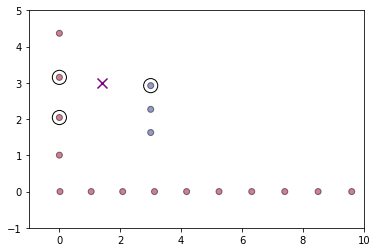

The test data point is classified as class 1 based on Euclidean distance.


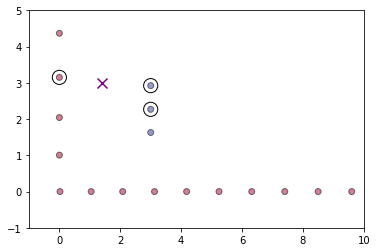

The test data point is classified as class 2 based on Manhattan distance.


In [35]:
knn_test=KNN(3)
test_point = np.array([1.4, 3])
colors = ['red', 'blue', 'green']
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', alpha=0.5)
plt.scatter(test_point[0], test_point[1], color='purple', s=100, marker='x')
plt.xlim(-1, 10)
plt.ylim(-1, 5)
knn_test.fit(X,y)
indices,prediction = knn_test.predict(test_point,distance_func='euclidean',test_mode=True)
for i in indices:
    plt.scatter(X[i, 0], X[i, 1], facecolors='none', edgecolors='black', s=200)
plt.savefig('./images/1.png')
plt.show()
print('The test data point is classified as class', prediction, 'based on Euclidean distance.')

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', alpha=0.5)
plt.scatter(test_point[0], test_point[1], color='purple', s=100, marker='x')
plt.xlim(-1, 10)
plt.ylim(-1, 5)
indices,prediction = knn_test.predict(test_point,distance_func='manhattan',test_mode=True)

for i in indices:
    plt.scatter(X[i, 0], X[i, 1], facecolors='none', edgecolors='black', s=200)
plt.savefig('./images/2.png')
plt.show()
print('The test data point is classified as class', prediction, 'based on Manhattan distance.')

In [ ]:
#https://www.python-engineer.com/courses/mlfromscratch/01_knn/